# Kong-Qian-Police Traffic Stops

Based on a [San Diego news article](https://www.sandiegouniontribune.com/news/watchdog/story/2022-01-16/stopped-by-police-in-san-diego-a-lot-depends-on-where-you-live-drive), an analysis showed that “some areas with large minority populations saw more enforcement than mostly White areas with similar crime totals”. With this, we want to see if we can get the same results using the San Diego police dataset, provided by the Open Police Project, and perhaps dig deeper into different factors that may contribute to or even result from this. We are hoping to see whether there’s any racial discrimination against certain populations based on the location of the stop along with the driver’s race. We can even investigate whether this leads to more warnings, citations, or arrests depending on the driver’s race. 

After taking a look at the dataset, we realized that it unfortunately does not have a location attribute, but instead a police service area number. With the help of the shapefiles provided from the same data source, we were able to get the 9 different police districts in San Diego county along with its precise location in the geometry column. Within each of the districts, there are multiple [service area numbers](https://www.sandiego.gov/sites/default/files/cros_area_map.pdf), to which we plan on merging the datasets to get the precise geometry for each police stop. This will help us potentially look into where people got stopped and if that location is in an area that has a predominantly minority population or white. Thus we will need to geoenrich the geometries or get census data for San Diego county to figure out the demographics of each district. The data itself, however, is fairly cleaned already with the only slight issue being some columns like service_areas having unknown or random values. But overall the data available is capable of helping us determine and even crossrefrence who is getting stopped the most in a certain district and if that area is largely populated by miniorites or not. 

### NOTES
important links: 

- https://api.census.gov/data/2016/acs/acs1/variables.html
- https://geographicdata.science/book/data/sandiego/sandiego_tracts_cleaning.html
- https://afraenkel.github.io/fairness-algo-decision/assignments/inequity-analysis/

potential downfalls: 
- acs census data from the cenpy api currently only has 2017 data while the police dataset from Stanford is from 2020. 

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import cenpy
import matplotlib.pyplot as plt

/Users/kelkong/opt/miniconda3/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(
/Users/kelkong/opt/miniconda3/lib/python3.9/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


# Data Collection

In [2]:
df = pd.read_csv('ca_san_diego_2020_04_01.csv')
#service_divisions = gpd.read_file('shapefiles/divisions_datasd.shp')
#service_divisions = gpd.read_file('/Users/brian/Downloads/ca_san_diego_shapefiles/divisions_datasd.shp')
service_divisions = gpd.read_file('ca_san_diego_shapefiles/divisions_datasd.shp')

In [3]:
acs = cenpy.products.ACS(2017)
vars_to_download = {
    #"B01003_001E": "total_pop",           # Total population
    #"B02001_002E": "white",     # Total white population
    #"B02001_003E": "black",
    #"B02001_004E": "native american",
    #"B02001_005E": "asian",
    #"B02001_006E": "pacific islander",
    #"B02001_007E": "other",
    "B03002_001E": "total_pop",
    "B03002_003E": "white",
    "B03002_004E": "black",
    "B03002_005E": "native american",
    "B03002_006E": "asian",
    "B03002_007E": "pacific islander",
    "B03002_008E": "other_1",
    "B03002_009E": "other_2",
    "B03002_010E": "other_3",
    "B03002_011E": "other_4",
    "B03002_012E": "hispanic",
}
vars_to_download_l = list(vars_to_download.keys())

In [4]:
db = acs.from_msa("San Diego, CA",
                  level="tract",
                  variables=vars_to_download_l
                 )

/Users/kelkong/opt/miniconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/Users/kelkong/opt/miniconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/Users/kelkong/opt/miniconda3/lib/python3.9/site-packages/cenpy/products.py:748: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `pred

In [5]:
var_names = acs.variables\
               .reindex(vars_to_download)\
               [["label", "concept"]]\
               .reset_index()\
               .rename(columns={"index": "var_id"})
var_names["short_name"] = var_names["var_id"].map(vars_to_download)
db = db.rename(columns=vars_to_download)

In [6]:
db = db.to_crs(2230)
db.head()

,GEOID,geometry,total_pop,white,black,native american,asian,pacific islander,other_1,other_2,other_3,other_4,hispanic,NAME,state,county,tract
0,06073018510,"POLYGON ((6222400.870 2021313.142, 6222599.301...",3057.0,1212.0,133.0,7.0,103.0,5.0,8.0,89.0,7.0,82.0,1500.0,"Census Tract 185.10, San Diego County, California",06,073,018510
1,06073019803,"POLYGON ((6232169.917 2011395.925, 6232180.359...",4937.0,3495.0,88.0,43.0,421.0,0.0,0.0,251.0,0.0,251.0,639.0,"Census Tract 198.03, San Diego County, California",06,073,019803
2,06073017502,"POLYGON ((6243828.072 1962813.808, 6243881.039...",3959.0,2365.0,19.0,8.0,114.0,55.0,7.0,107.0,0.0,107.0,1284.0,"Census Tract 175.02, San Diego County, California",06,073,017502
3,06073017303,"POLYGON ((6244663.651 1950631.608, 6244807.518...",3009.0,2562.0,19.0,0.0,91.0,0.0,0.0,71.0,0.0,71.0,266.0,"Census Tract 173.03, San Diego County, California",06,073,017303
4,06073017200,"POLYGON ((6247400.704 1938073.403, 6247688.230...",4338.0,3960.0,21.0,0.0,112.0,0.0,0.0,42.0,0.0,42.0,203.0,"Census Tract 172, San Diego County, California",06,073,017200


In [7]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [8]:
df.head()

,raw_row_number,date,time,service_area,subject_age,subject_race,subject_sex,type,arrest_made,citation_issued,warning_issued,outcome,contraband_found,search_conducted,search_person,search_vehicle,search_basis,reason_for_search,reason_for_stop,raw_action_taken,raw_subject_race_description
0,1,2014-01-01,01:25:00,110,24.0,white,male,vehicular,False,True,False,citation,NaN,False,False,False,NaN,NaN,Moving Violation,Citation,WHITE
1,2,2014-01-01,05:47:00,320,42.0,white,male,vehicular,False,False,True,warning,NaN,False,False,False,NaN,NaN,Moving Violation,Verbal Warning,WHITE
2,3,2014-01-01,07:46:00,320,29.0,asian/pacific islander,male,vehicular,False,False,True,warning,NaN,False,False,False,NaN,NaN,Moving Violation,Verbal Warning,LAOTIAN
3,4,2014-01-01,08:10:00,610,23.0,white,male,vehicular,False,True,False,citation,NaN,False,False,False,NaN,NaN,Moving Violation,Citation,WHITE
4,5,2014-01-01,08:35:00,930,35.0,hispanic,male,vehicular,False,True,False,citation,NaN,False,False,False,NaN,NaN,Equipment Violation,Citation,HISPANIC


# Exploratory Data Analysis

In [9]:
df['subject_race'].value_counts()

white                     162226
hispanic                  117083
black                      42705
asian/pacific islander     32541
other                      27238
Name: subject_race, dtype: int64

In [10]:
print("Police Service Areas and the count of police stops in those areas")
df['service_area'].value_counts()

Police Service Areas and the count of police stops in those areas


310         31511
120         30838
520         29514
710         26824
240         25428
930         24797
110         24300
620         20951
230         19899
610         18999
720         17430
320         16529
430         15632
510         14897
810         13929
440         13710
830         13295
820         12268
Unknown     11240
530           649
630           201
130            90
County         42
840            28
Bulletin       26
Name: service_area, dtype: int64

In [11]:
temp = df.groupby('service_area')['subject_race'].value_counts()
pd.DataFrame(temp)

subject_race
service_area subject_race                        
110          white                          14505
             hispanic                        4418
             asian/pacific islander          2018
             other                           1687
             black                           1354
120          white                          20767
             hispanic                        4477
             other                           2324
             black                           1752
             asian/pacific islander          1419
130          white                             55
             hispanic                          20
             black                              7
             other                              4
             asian/pacific islander             3
230          white                          10967
             asian/pacific islander          2894
             hispanic                        2628
             other                           2247
             black                           1136
240          white                          10439
             asian/pacific islander          5953
             hispanic                        3785
             other                           3493
             black                           1730
310          white                          15851
             hispanic                        6106
             asian/pacific islander          3619
             black                           3088
             other                           2718
320          white                           8832
             hispanic                        3226
             black                           1983
             other                           1390
             asian/pacific islander          1059
430          hispanic                        5809
             black                           5388
             white                           2024
             asian/pacific islander          1621
             other                            765
440          hispanic                        7274
             black                           3913
             white                           1224
             asian/pacific islander           705
             other                            565
510          hispanic                        8142
             white                           3549
             black                           2230
             other                            510
             asian/pacific islander           446
520          white                          14508
             hispanic                        6310
             black                           4044
             other                           3194
             asian/pacific islander          1377
530          white                            388
             hispanic                         136
             asian/pacific islander            53
             black                             37
             other                             33
610          white                          12456
             hispanic                        3430
             black                           1408
             other                            832
             asian/pacific islander           800
620          white                          11423
             hispanic                        4713
             black                           1987
             asian/pacific islander          1593
             other                           1161
630          white                            104
             hispanic                          37
             asian/pacific islander            30
             black                             16
             other                             13
710          hispanic                       21896
             white                           3087
             black                            776
             asian/pacific islander  

In [12]:
df.groupby('outcome')['subject_race'].value_counts()

outcome   subject_race          
arrest    white                      1771
          hispanic                   1714
          black                       857
          asian/pacific islander      309
          other                       160
citation  white                     96062
          hispanic                  67298
          black                     20523
          asian/pacific islander    17805
          other                     17289
warning   white                     50107
          hispanic                  33461
          black                     16606
          asian/pacific islander    11887
          other                      7049
Name: subject_race, dtype: int64

# Investigation 

In [13]:
print("Police districts in San Diego")
service_divisions

Police districts in San Diego


,objectid,div_num,div_name,geometry
0,1,1,NORTHERN,"POLYGON ((6257399.474 1913720.405, 6258021.781..."
1,2,2,NORTHEASTERN,"POLYGON ((6329136.046 1985638.386, 6329132.056..."
2,3,3,EASTERN,"POLYGON ((6323355.804 1898933.226, 6324130.958..."
3,4,4,SOUTHEASTERN,"POLYGON ((6314753.250 1851441.908, 6314774.253..."
4,5,5,CENTRAL,"POLYGON ((6287304.000 1850636.000, 6287303.000..."
5,6,6,WESTERN,"POLYGON ((6280788.358 1873275.706, 6280793.053..."
6,7,7,SOUTHERN,"POLYGON ((6294084.233 1801858.103, 6294115.999..."
7,8,8,MID-CITY,"POLYGON ((6300696.000 1863112.000, 6300797.593..."
8,9,9,NORTHWESTERN,"POLYGON ((6290347.459 1952824.477, 6290674.051..."


In [14]:
districts = {'NORTHERN': ['110','120','130'], 'NORTHEASTERN': ['230','240'], "EASTERN": ['310','320'], 'SOUTHEASTERN':['430','440'], 'CENTRAL':['510','520','530'], 'WESTERN':['610','620','630'], 'SOUTHERN':['710','720'], 'MID-CITY':['810','820','830', '840'], 'NORTHWESTERN':['930']}
districts

{'NORTHERN': ['110', '120', '130'],
 'NORTHEASTERN': ['230', '240'],
 'EASTERN': ['310', '320'],
 'SOUTHEASTERN': ['430', '440'],
 'CENTRAL': ['510', '520', '530'],
 'WESTERN': ['610', '620', '630'],
 'SOUTHERN': ['710', '720'],
 'MID-CITY': ['810', '820', '830', '840'],
 'NORTHWESTERN': ['930']}

In [15]:
df['service_area'].unique()

array(['110', '320', '610', '930', '820', '710', '120', '230', '240',
       '720', '430', '310', '510', 'Unknown', '810', '440', '830', '520',
       '620', '630', '130', '530', '840', 'County', 'Bulletin'],
      dtype=object)

In [16]:
service_divisions['service_area'] = service_divisions['div_name'].map(districts)
service_divisions

,objectid,div_num,div_name,geometry,service_area
0,1,1,NORTHERN,"POLYGON ((6257399.474 1913720.405, 6258021.781...","[110, 120, 130]"
1,2,2,NORTHEASTERN,"POLYGON ((6329136.046 1985638.386, 6329132.056...","[230, 240]"
2,3,3,EASTERN,"POLYGON ((6323355.804 1898933.226, 6324130.958...","[310, 320]"
3,4,4,SOUTHEASTERN,"POLYGON ((6314753.250 1851441.908, 6314774.253...","[430, 440]"
4,5,5,CENTRAL,"POLYGON ((6287304.000 1850636.000, 6287303.000...","[510, 520, 530]"
5,6,6,WESTERN,"POLYGON ((6280788.358 1873275.706, 6280793.053...","[610, 620, 630]"
6,7,7,SOUTHERN,"POLYGON ((6294084.233 1801858.103, 6294115.999...","[710, 720]"
7,8,8,MID-CITY,"POLYGON ((6300696.000 1863112.000, 6300797.593...","[810, 820, 830, 840]"
8,9,9,NORTHWESTERN,"POLYGON ((6290347.459 1952824.477, 6290674.051...",[930]


In [17]:
service_divisions = service_divisions.explode('service_area')
service_divisions = service_divisions[['service_area','geometry']]
service_divisions

,service_area,geometry
0,110,"POLYGON ((6257399.474 1913720.405, 6258021.781..."
0,120,"POLYGON ((6257399.474 1913720.405, 6258021.781..."
0,130,"POLYGON ((6257399.474 1913720.405, 6258021.781..."
1,230,"POLYGON ((6329136.046 1985638.386, 6329132.056..."
1,240,"POLYGON ((6329136.046 1985638.386, 6329132.056..."
2,310,"POLYGON ((6323355.804 1898933.226, 6324130.958..."
2,320,"POLYGON ((6323355.804 1898933.226, 6324130.958..."
3,430,"POLYGON ((6314753.250 1851441.908, 6314774.253..."
3,440,"POLYGON ((6314753.250 1851441.908, 6314774.253..."
4,510,"POLYGON ((6287304.000 1850636.000, 6287303.000..."


In [18]:
test = gpd.sjoin(left_df=service_divisions, right_df=db, how='left')

In [19]:
test.head()

,service_area,geometry,index_right,GEOID,total_pop,white,black,native american,asian,pacific islander,other_1,other_2,other_3,other_4,hispanic,NAME,state,county,tract
0,110,"POLYGON ((6257399.474 1913720.405, 6258021.781...",449,06073009400,4645.0,2641.0,395.0,102.0,121.0,9.0,37.0,154.0,0.0,154.0,1186.0,"Census Tract 94, San Diego County, California",06,073,009400
0,110,"POLYGON ((6257399.474 1913720.405, 6258021.781...",183,06073008511,4336.0,1712.0,176.0,0.0,906.0,127.0,0.0,131.0,43.0,88.0,1284.0,"Census Tract 85.11, San Diego County, California",06,073,008511
0,110,"POLYGON ((6257399.474 1913720.405, 6258021.781...",170,06073008506,4753.0,2555.0,64.0,0.0,588.0,0.0,0.0,78.0,0.0,78.0,1468.0,"Census Tract 85.06, San Diego County, California",06,073,008506
0,110,"POLYGON ((6257399.474 1913720.405, 6258021.781...",21,06073008505,6571.0,3036.0,81.0,15.0,1459.0,109.0,21.0,154.0,26.0,128.0,1696.0,"Census Tract 85.05, San Diego County, California",06,073,008505
0,110,"POLYGON ((6257399.474 1913720.405, 6258021.781...",582,06073008345,4170.0,2716.0,125.0,16.0,633.0,0.0,0.0,100.0,0.0,100.0,580.0,"Census Tract 83.45, San Diego County, California",06,073,008345


In [20]:
divisions = test.groupby('service_area').sum()
divisions['other'] = divisions['total_pop'] - divisions['white'] - divisions['black'] - divisions['asian'] - divisions['pacific islander'] - divisions['hispanic']
divisions['asian/pacific islander'] = divisions['asian'] + divisions['pacific islander'] 
#divisions['other'] = divisions['native american'] + divisions['other_1'] + divisions['other_2'] + divisions['other_3'] + divisions['other_4']
divisions = divisions.reset_index()[['service_area','total_pop','white','black','asian/pacific islander','hispanic','other']]

In [21]:
final_divisions = divisions.merge(service_divisions, on='service_area')
final_divisions

,service_area,total_pop,white,black,asian/pacific islander,hispanic,other,geometry
0,110,274271.0,167769.0,6907.0,40788.0,47961.0,10846.0,"POLYGON ((6257399.474 1913720.405, 6258021.781..."
1,120,274271.0,167769.0,6907.0,40788.0,47961.0,10846.0,"POLYGON ((6257399.474 1913720.405, 6258021.781..."
2,130,274271.0,167769.0,6907.0,40788.0,47961.0,10846.0,"POLYGON ((6257399.474 1913720.405, 6258021.781..."
3,230,379929.0,194353.0,8910.0,106724.0,49681.0,20261.0,"POLYGON ((6329136.046 1985638.386, 6329132.056..."
4,240,379929.0,194353.0,8910.0,106724.0,49681.0,20261.0,"POLYGON ((6329136.046 1985638.386, 6329132.056..."
5,310,267640.0,157171.0,14162.0,29680.0,54041.0,12586.0,"POLYGON ((6323355.804 1898933.226, 6324130.958..."
6,320,267640.0,157171.0,14162.0,29680.0,54041.0,12586.0,"POLYGON ((6323355.804 1898933.226, 6324130.958..."
7,430,299131.0,43770.0,39683.0,51147.0,155721.0,8810.0,"POLYGON ((6314753.250 1851441.908, 6314774.253..."
8,440,299131.0,43770.0,39683.0,51147.0,155721.0,8810.0,"POLYGON ((6314753.250 1851441.908, 6314774.253..."
9,510,162981.0,67667.0,11426.0,9464.0,69987.0,4437.0,"POLYGON ((6287304.000 1850636.000, 6287303.000..."


In [22]:
df2 = df.merge(final_divisions, how='left')
df2.head()

,raw_row_number,date,time,service_area,subject_age,subject_race,subject_sex,type,arrest_made,citation_issued,warning_issued,outcome,contraband_found,search_conducted,search_person,search_vehicle,search_basis,reason_for_search,reason_for_stop,raw_action_taken,raw_subject_race_description,total_pop,white,black,asian/pacific islander,hispanic,other,geometry
0,1,2014-01-01,01:25:00,110,24.0,white,male,vehicular,False,True,False,citation,NaN,False,False,False,NaN,NaN,Moving Violation,Citation,WHITE,274271.0,167769.0,6907.0,40788.0,47961.0,10846.0,"POLYGON ((6257399.474 1913720.405, 6258021.781..."
1,2,2014-01-01,05:47:00,320,42.0,white,male,vehicular,False,False,True,warning,NaN,False,False,False,NaN,NaN,Moving Violation,Verbal Warning,WHITE,267640.0,157171.0,14162.0,29680.0,54041.0,12586.0,"POLYGON ((6323355.804 1898933.226, 6324130.958..."
2,3,2014-01-01,07:46:00,320,29.0,asian/pacific islander,male,vehicular,False,False,True,warning,NaN,False,False,False,NaN,NaN,Moving Violation,Verbal Warning,LAOTIAN,267640.0,157171.0,14162.0,29680.0,54041.0,12586.0,"POLYGON ((6323355.804 1898933.226, 6324130.958..."
3,4,2014-01-01,08:10:00,610,23.0,white,male,vehicular,False,True,False,citation,NaN,False,False,False,NaN,NaN,Moving Violation,Citation,WHITE,205228.0,129765.0,8069.0,17832.0,41948.0,7614.0,"POLYGON ((6280788.358 1873275.706, 6280793.053..."
4,5,2014-01-01,08:35:00,930,35.0,hispanic,male,vehicular,False,True,False,citation,NaN,False,False,False,NaN,NaN,Equipment Violation,Citation,HISPANIC,191122.0,105880.0,3566.0,53185.0,18776.0,9715.0,"POLYGON ((6290347.459 1952824.477, 6290674.051..."


In [23]:
temp = df.groupby('service_area')['subject_race'].value_counts(normalize=True)
pd.DataFrame(temp)

subject_race
service_area subject_race                        
110          white                       0.604829
             hispanic                    0.184221
             asian/pacific islander      0.084146
             other                       0.070344
             black                       0.056459
120          white                       0.675591
             hispanic                    0.145646
             other                       0.075604
             black                       0.056996
             asian/pacific islander      0.046163
130          white                       0.617978
             hispanic                    0.224719
             black                       0.078652
             other                       0.044944
             asian/pacific islander      0.033708
230          white                       0.551882
             asian/pacific islander      0.145632
             hispanic                    0.132246
             other                       0.113074
             black                       0.057166
240          white                       0.410984
             asian/pacific islander      0.234370
             hispanic                    0.149016
             other                       0.137520
             black                       0.068110
310          white                       0.505098
             hispanic                    0.194570
             asian/pacific islander      0.115321
             black                       0.098400
             other                       0.086610
320          white                       0.535597
             hispanic                    0.195634
             black                       0.120255
             other                       0.084294
             asian/pacific islander      0.064221
430          hispanic                    0.372205
             black                       0.345230
             white                       0.129685
             asian/pacific islander      0.103864
             other                       0.049016
440          hispanic                    0.531686
             black                       0.286017
             white                       0.089467
             asian/pacific islander      0.051531
             other                       0.041298
510          hispanic                    0.547288
             white                       0.238556
             black                       0.149896
             other                       0.034281
             asian/pacific islander      0.029979
520          white                       0.492916
             hispanic                    0.214385
             black                       0.137397
             other                       0.108518
             asian/pacific islander      0.046784
530          white                       0.599691
             hispanic                    0.210201
             asian/pacific islander      0.081917
             black                       0.057187
             other                       0.051005
610          white                       0.658142
             hispanic                    0.181232
             black                       0.074395
             other                       0.043961
             asian/pacific islander      0.042270
620          white                       0.547157
             hispanic                    0.225751
             black                       0.095177
             asian/pacific islander      0.076304
             other                       0.055611
630          white                       0.520000
             hispanic                    0.185000
             asian/pacific islander      0.150000
             black                       0.080000
             other                       0.065000
710          hispanic                    0.816893
             white                       0.115169
             black                       0.028951
             asian/pacific islander  

In [24]:
#final_divisions.groupby('service_area')

In [25]:
df.head(10)

,raw_row_number,date,time,service_area,subject_age,subject_race,subject_sex,type,arrest_made,citation_issued,warning_issued,outcome,contraband_found,search_conducted,search_person,search_vehicle,search_basis,reason_for_search,reason_for_stop,raw_action_taken,raw_subject_race_description
0,1,2014-01-01,01:25:00,110,24.0,white,male,vehicular,False,True,False,citation,NaN,False,False,False,NaN,NaN,Moving Violation,Citation,WHITE
1,2,2014-01-01,05:47:00,320,42.0,white,male,vehicular,False,False,True,warning,NaN,False,False,False,NaN,NaN,Moving Violation,Verbal Warning,WHITE
2,3,2014-01-01,07:46:00,320,29.0,asian/pacific islander,male,vehicular,False,False,True,warning,NaN,False,False,False,NaN,NaN,Moving Violation,Verbal Warning,LAOTIAN
3,4,2014-01-01,08:10:00,610,23.0,white,male,vehicular,False,True,False,citation,NaN,False,False,False,NaN,NaN,Moving Violation,Citation,WHITE
4,5,2014-01-01,08:35:00,930,35.0,hispanic,male,vehicular,False,True,False,citation,NaN,False,False,False,NaN,NaN,Equipment Violation,Citation,HISPANIC
5,6,2014-01-01,08:39:00,820,30.0,hispanic,male,vehicular,False,False,True,warning,NaN,False,False,False,NaN,NaN,Equipment Violation,Verbal Warning,HISPANIC
6,7,2014-01-01,09:13:00,710,19.0,hispanic,female,vehicular,False,True,False,citation,NaN,False,False,False,NaN,NaN,Moving Violation,Citation,HISPANIC
7,8,2014-01-01,09:50:00,120,32.0,white,male,vehicular,False,False,True,warning,NaN,False,False,False,NaN,NaN,Moving Violation,Written Warning,WHITE
8,9,2014-01-01,10:00:00,120,36.0,white,male,vehicular,False,True,False,citation,NaN,False,False,False,NaN,NaN,Moving Violation,Citation,WHITE
9,10,2014-01-01,10:40:00,120,27.0,hispanic,male,vehicular,False,True,False,citation,NaN,False,False,False,NaN,NaN,Moving Violation,Citation,HISPANIC


# Demographic Parity

1. In the Demographic Parity view of fairness, the demographics of people who are ultimately searched after being stopped should be proportional the demographics of the people who were stopped.  if 80% of people stopped were Hispanic, then 80% of the people who were searched should also be 80%.


In [26]:
len(df)/2

191513.5

In [27]:
#train = df.iloc[:191513,:]
test = df#.iloc[191513:,:]

In [28]:
test.head()

,raw_row_number,date,time,service_area,subject_age,subject_race,subject_sex,type,arrest_made,citation_issued,warning_issued,outcome,contraband_found,search_conducted,search_person,search_vehicle,search_basis,reason_for_search,reason_for_stop,raw_action_taken,raw_subject_race_description
0,1,2014-01-01,01:25:00,110,24.0,white,male,vehicular,False,True,False,citation,NaN,False,False,False,NaN,NaN,Moving Violation,Citation,WHITE
1,2,2014-01-01,05:47:00,320,42.0,white,male,vehicular,False,False,True,warning,NaN,False,False,False,NaN,NaN,Moving Violation,Verbal Warning,WHITE
2,3,2014-01-01,07:46:00,320,29.0,asian/pacific islander,male,vehicular,False,False,True,warning,NaN,False,False,False,NaN,NaN,Moving Violation,Verbal Warning,LAOTIAN
3,4,2014-01-01,08:10:00,610,23.0,white,male,vehicular,False,True,False,citation,NaN,False,False,False,NaN,NaN,Moving Violation,Citation,WHITE
4,5,2014-01-01,08:35:00,930,35.0,hispanic,male,vehicular,False,True,False,citation,NaN,False,False,False,NaN,NaN,Equipment Violation,Citation,HISPANIC


In [37]:
def aspercent(column,decimals=2):
    # assert decimals >= 0
    return column #(round(column*100,decimals).astype(str) + "%")

In [30]:
demographic_groups = test['subject_race'].value_counts().to_dict()
demographic_groups

{'white': 162226,
 'hispanic': 117083,
 'black': 42705,
 'asian/pacific islander': 32541,
 'other': 27238}

In [31]:
percentage_of_groups = aspercent(test['subject_race'].value_counts(normalize=True), decimals = 2).to_dict()
percentage_of_groups

{'white': '42.49%',
 'hispanic': '30.67%',
 'black': '11.19%',
 'asian/pacific islander': '8.52%',
 'other': '7.13%'}

In [32]:
searched_groups = test[test['search_conducted'] == True]['subject_race'].value_counts().to_dict()
searched_groups

{'hispanic': 6501,
 'white': 4510,
 'black': 3873,
 'asian/pacific islander': 910,
 'other': 451}

In [33]:
percentage_searched = aspercent(test[test['search_conducted'] == True]['subject_race'].value_counts(normalize=True),decimals=2).to_dict()
percentage_searched

{'hispanic': '40.02%',
 'white': '27.76%',
 'black': '23.84%',
 'asian/pacific islander': '5.6%',
 'other': '2.78%'}

In [34]:
searched = pd.DataFrame([demographic_groups, percentage_of_groups, searched_groups, percentage_searched],index=['Total # of Stops', 'Percent of Stops', '# of Searched', 'Percent of Searched']).T
index = searched.index
index.name = "Race"
searched.style.set_caption('Demographic Parity Fairness: Searched').set_table_styles([{
    'selector': 'caption',
    'props': [
        ('color', 'Black'),
        ('font-size', '15px'),
        ('font-style', 'italic'),
        ('font-weight', 'bold'),
        ('text-align', 'center')
    ]
}])

,Total # of Stops,Percent of Stops,# of Searched,Percent of Searched
Race,,,,
white,162226,42.49%,4510,27.76%
hispanic,117083,30.67%,6501,40.02%
black,42705,11.19%,3873,23.84%
asian/pacific islander,32541,8.52%,910,5.6%
other,27238,7.13%,451,2.78%


Text(0.5, 1.0, 'Distribution of Stops and Searches per Race')

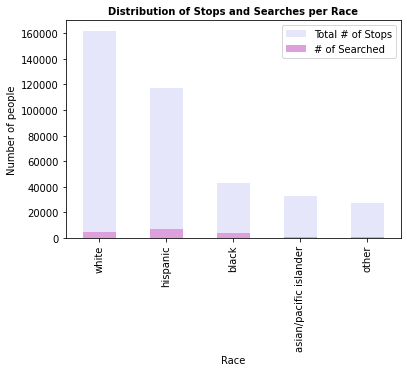

In [35]:
ax = searched.plot(y="Total # of Stops", use_index=True , kind="bar", color='lavender')
searched.plot(y="# of Searched", kind="bar", ax=ax, color="plum")
plt.xlabel("Race")
plt.ylabel('Number of people')
plt.title("Distribution of Stops and Searches per Race", fontdict={'fontsize': 10, 'fontweight':'bold'})

In [38]:
searched.plot(y= ['Percent of Stops',"Percent of Searched"], use_index=True, kind='bar', color =['paleturquoise','teal'])
plt.xlabel("Race")
plt.ylabel('Percentages')
plt.title("Comparison between Percentage of Stops and Searches per Race", fontdict={'fontsize': 9, 'fontweight':'bold'})

TypeError: no numeric data to plot

In [ ]:
searched_person_groups = test[test['search_person'] == True]['subject_race'].value_counts().to_dict()
searched_person_groups

In [ ]:
percentage_searched_person = aspercent(test[test['search_person'] == True]['subject_race'].value_counts(normalize=True),decimals=2).to_dict()
percentage_searched_person

In [ ]:
searched_person = pd.DataFrame([demographic_groups, percentage_of_groups, searched_person_groups, percentage_searched_person],index=['Total # of Stops', 'Percent of Stops', '# of Searched (Person)', 'Percent of Searched (Person)']).T
index = searched_person.index
index.name = "Race"
searched_person.style.set_caption('Demographic Parity Fairness: Searched (Person)').set_table_styles([{
    'selector': 'caption',
    'props': [
        ('color', 'Black'),
        ('font-size', '15px'),
        ('font-style', 'italic'),
        ('font-weight', 'bold'),
        ('text-align', 'center')
    ]
}])

In [ ]:
ax = searched_person.plot(y="Total # of Stops", use_index=True , kind="bar", color='lavender')
searched_person.plot(y="# of Searched (Person)", kind="bar", ax=ax, color="plum")
plt.xlabel("Race")
plt.ylabel('Number of people')
plt.title("Distribution of Stops and Searches (Person) per Race", fontdict={'fontsize': 10, 'fontweight':'bold'})

In [ ]:
searched_person.plot(y= ['Percent of Stops',"Percent of Searched (Person)"], use_index=True, kind='bar', color =['paleturquoise','teal'])
plt.xlabel("Race")
plt.ylabel('Percentages')
plt.title("Comparison between Percentage of Stops and Searches (Person) per Race", fontdict={'fontsize': 9, 'fontweight':'bold'})

In [ ]:
searched_vehicle_groups = test[test['search_vehicle'] == True]['subject_race'].value_counts().to_dict()
searched_vehicle_groups

In [ ]:
percentage_searched_vehicle = aspercent(test[test['search_vehicle'] == True]['subject_race'].value_counts(normalize=True),decimals=2).to_dict()
percentage_searched_vehicle

In [ ]:
searched_vehicle =pd.DataFrame([demographic_groups, percentage_of_groups, searched_vehicle_groups, percentage_searched_vehicle],index=['Total # of Stops', 'Percent of Stops', '# of Searched (Vehicles)', 'Percent of Searched (Vehicles)']).T
index = searched_vehicle.index
index.name = "Race"
searched_vehicle.style.set_caption('Demographic Parity Fairness: Searched (Vehicles)').set_table_styles([{
    'selector': 'caption',
    'props': [
        ('color', 'Black'),
        ('font-size', '15px'),
        ('font-style', 'italic'),
        ('font-weight', 'bold'),
        ('text-align', 'center')
    ]
}])

In [ ]:
ax = searched_vehicle.plot(y="Total # of Stops", use_index=True , kind="bar", color='lavender')
searched_vehicle.plot(y="# of Searched (Vehicles)", kind="bar", ax=ax, color="plum")
plt.xlabel("Race")
plt.ylabel('Number of people')
plt.title("Distribution of Stops and Searches (Vehicles) per Race", fontdict={'fontsize': 10, 'fontweight':'bold'})

In [ ]:
searched_vehicle.plot(y= ['Percent of Stops',"Percent of Searched (Vehicles)"], use_index=True, kind='bar', color =['paleturquoise','teal'])
plt.xlabel("Race")
plt.ylabel('Percentages')
plt.title("Comparison between Percentage of Stops and Searches (Vehicles) per Race", fontdict={'fontsize': 9, 'fontweight':'bold'})

In [ ]:
arrested_groups = test[test['arrest_made'] == True]['subject_race'].value_counts().to_dict()
arrested_groups

In [ ]:
percentage_arrested = aspercent(test[test['arrest_made'] == True]['subject_race'].value_counts(normalize=True),decimals=2).to_dict()
percentage_arrested

In [ ]:
arrested = pd.DataFrame([demographic_groups, percentage_of_groups, arrested_groups, percentage_arrested],index=['Total # of Stops', 'Percent of Stops', '# of Arrested', 'Percent of Arrested']).T
index = arrested.index
index.name = "Race"
arrested.style.set_caption('Demographic Parity Fairness: Arrested').set_table_styles([{
    'selector': 'caption',
    'props': [
        ('color', 'Black'),
        ('font-size', '15px'),
        ('font-style', 'italic'),
        ('font-weight', 'bold'),
        ('text-align', 'center')
    ]
}])

In [ ]:
ax = arrested.plot(y="Total # of Stops", use_index=True , kind="bar", color='lavender')
arrested.plot(y="# of Arrested", kind="bar", ax=ax, color="plum")
plt.xlabel("Race")
plt.ylabel('Number of people')
plt.title("Distribution of Stops and Arrests per Race", fontdict={'fontsize': 10, 'fontweight':'bold'})

In [ ]:
arrested.plot(y= ['Percent of Stops',"Percent of Arrested"], use_index=True, kind='bar', color =['paleturquoise','teal'])
plt.xlabel("Race")
plt.ylabel('Percentages')
plt.title("Comparison between Percentage of Stops and Arrests per Race", fontdict={'fontsize': 9, 'fontweight':'bold'})

In [ ]:
citation_groups = test[test['citation_issued'] == True]['subject_race'].value_counts().to_dict()
citation_groups

In [ ]:
percentage_citation = aspercent(test[test['citation_issued'] == True]['subject_race'].value_counts(normalize=True),decimals=2).to_dict()
percentage_citation

In [ ]:
citation = pd.DataFrame([demographic_groups, percentage_of_groups, citation_groups, percentage_citation],index=['Total # of Stops', 'Percent of Stops', '# of Citations Issued', 'Percent of Citations Issued']).T
index = citation.index
index.name = "Race"
citation.style.set_caption('Demographic Parity Fairness: Citations Issued').set_table_styles([{
    'selector': 'caption',
    'props': [
        ('color', 'Black'),
        ('font-size', '15px'),
        ('font-style', 'italic'),
        ('font-weight', 'bold'),
        ('text-align', 'center')
    ]
}])

In [ ]:
ax = citation.plot(y="Total # of Stops", use_index=True , kind="bar", color='lavender')
citation.plot(y="# of Citations Issued", kind="bar", ax=ax, color="plum")
plt.xlabel("Race")
plt.ylabel('Number of people')
plt.title("Distribution of Stops and Citations Issued per Race", fontdict={'fontsize': 10, 'fontweight':'bold'})

In [ ]:
citation.plot(y= ['Percent of Stops',"Percent of Citations Issued"], use_index=True, kind='bar', color =['paleturquoise','teal'])
plt.xlabel("Race")
plt.ylabel('Percentages')
plt.title("Comparison between Percentage of Stops and Citations Issued per Race", fontdict={'fontsize': 9, 'fontweight':'bold'})

In [ ]:
warning_issued_groups = test[test['warning_issued'] == True]['subject_race'].value_counts().to_dict()
warning_issued_groups

In [ ]:
percentage_warning_issued = aspercent(test[test['warning_issued'] == True]['subject_race'].value_counts(normalize=True),decimals=2).to_dict()
percentage_warning_issued

In [176]:
warning = pd.DataFrame([demographic_groups, percentage_of_groups, warning_issued_groups, percentage_warning_issued],index=['Total # of Stops', 'Percent of Stops', '# of Warnings Issued', 'Percent of Warnings Issued']).T
index = warning.index
index.name = "Race"
warning.style.set_caption('Demographic Parity Fairness: Warnings Issued').set_table_styles([{
    'selector': 'caption',
    'props': [
        ('color', 'Black'),
        ('font-size', '15px'),
        ('font-style', 'italic'),
        ('font-weight', 'bold'),
        ('text-align', 'center')
    ]
}])

,Total # of Stops,Percent of Stops,# of Warnings Issued,Percent of Warnings Issued
Race,,,,
white,162226,42.49%,50670,42.07%
hispanic,117083,30.67%,33863,28.12%
black,42705,11.19%,16780,13.93%
asian/pacific islander,32541,8.52%,11985,9.95%
other,27238,7.13%,7139,5.93%


Text(0.5, 1.0, 'Distribution of Stops and Warnings Issued per Race')

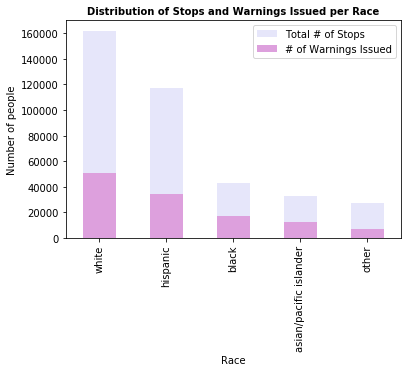

In [143]:
ax = warning.plot(y="Total # of Stops", use_index=True , kind="bar", color='lavender')
warning.plot(y="# of Warnings Issued", kind="bar", ax=ax, color="plum")
plt.xlabel("Race")
plt.ylabel('Number of people')
plt.title("Distribution of Stops and Warnings Issued per Race", fontdict={'fontsize': 10, 'fontweight':'bold'})
#warning.plot(y= ['# of Demographic Group',"# of Warnings Issued"], use_index=True, kind='bar')

Text(0.5, 1.0, 'Comparison between Percentage of Stops and Warnings Issued per Race')

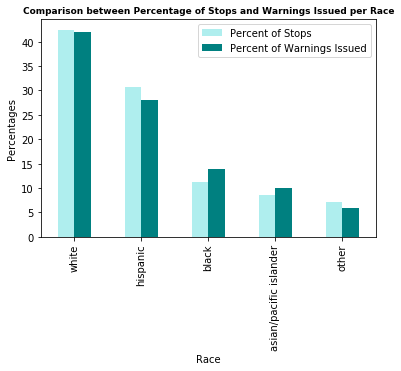

In [142]:
warning.plot(y= ['Percent of Stops',"Percent of Warnings Issued"], use_index=True, kind='bar', color =['paleturquoise','teal'])
plt.xlabel("Race")
plt.ylabel('Percentages')
plt.title("Comparison between Percentage of Stops and Warnings Issued per Race", fontdict={'fontsize': 9, 'fontweight':'bold'})